In [127]:
import keras.models
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [128]:

# Load datasets
ppg_data_combined = pd.read_excel('E:/dataset/PPG-BP/IEEE_ACCESS/combined_dataset.xlsx')

In [129]:
ppg_data_combined.head()

,Num.,subject_ID,Sex(M/F),Age(year),Height(cm),Weight(kg),Systolic Blood Pressure(mmHg),Diastolic Blood Pressure(mmHg),Heart Rate(b/m),BMI(kg/m^2),...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,1,2,Female,45,152,63,161,89,97,27.268006,...,1766,1766,1766,1833,1833,1827,1827,1827,1754,1754
1,1,2,Female,45,152,63,161,89,97,27.268006,...,1985,1985,2026,2026,2026,1977,1977,1997,1997,1997
2,1,2,Female,45,152,63,161,89,97,27.268006,...,1942,1900,1900,1938,1938,1938,1924,1924,1929,1929
3,2,3,Female,50,157,50,160,93,76,20.284799,...,2073,2072,2072,2072,2051,2051,2036,2036,2036,2045
4,2,3,Female,50,157,50,160,93,76,20.284799,...,2021,2010,2010,2010,2001,2001,2003,2003,2003,1989


In [130]:
ppg_data_combined.columns

Index(['Num.', 'subject_ID', 'Sex(M/F)', 'Age(year)', 'Height(cm)',
       'Weight(kg)', 'Systolic Blood Pressure(mmHg)',
       'Diastolic Blood Pressure(mmHg)', 'Heart Rate(b/m)', 'BMI(kg/m^2)',
       ...
       '2091', '2092', '2093', '2094', '2095', '2096', '2097', '2098', '2099',
       '2100'],
      dtype='object', length=2114)

In [131]:
ppg_data_combined['Sex(M/F)'] = ppg_data_combined['Sex(M/F)'].map({'Male': 1, 'Female': 0})

data_systolic = ppg_data_combined["Systolic Blood Pressure(mmHg)"]
data_diastolic = ppg_data_combined["Diastolic Blood Pressure(mmHg)"]
data_sex = ppg_data_combined["Sex(M/F)"]
data_age = ppg_data_combined["Age(year)"]
data_height = ppg_data_combined["Height(cm)"]
data_weight = ppg_data_combined["Weight(kg)"]
data_hr = ppg_data_combined["Heart Rate(b/m)"]
data_bmi = ppg_data_combined["BMI(kg/m^2)"]

ppg_data = ppg_data_combined.iloc[:,14:]

In [132]:
data_personal = pd.concat([data_sex, data_age, data_height, data_weight, data_hr, data_bmi], axis=1)


In [133]:
data_personal

,Sex(M/F),Age(year),Height(cm),Weight(kg),Heart Rate(b/m),BMI(kg/m^2)
0,0,45,152,63,97,27.268006
1,0,45,152,63,97,27.268006
2,0,45,152,63,97,27.268006
3,0,50,157,50,76,20.284799
4,0,50,157,50,76,20.284799
...,...,...,...,...,...,...
652,1,25,173,63,67,21.049818
653,1,25,173,63,67,21.049818
654,1,24,175,58,65,18.938776
655,1,24,175,58,65,18.938776


In [134]:
# Assuming bp_data has columns 'systolic' and 'diastolic'
# Normalize blood pressure data
bp_data = np.array([data_systolic, data_diastolic]).T
bp_data

array([[161,  89],
       [161,  89],
       [161,  89],
       ...,
       [108,  68],
       [108,  68],
       [108,  68]], dtype=int64)

In [135]:
# Split the data into training and testing sets
X_train2100, X_test2100, y_train, y_test = train_test_split(ppg_data, bp_data, test_size=0.25, random_state=42)
X_train6, X_test6, y_train, y_test = train_test_split(data_personal, bp_data, test_size=0.25, random_state=42)

In [136]:
# Reshape input to be [samples, time steps, features]
X_train2100 = np.reshape(X_train2100, (X_train2100.shape[0], 1, X_train2100.shape[1]))
X_test2100 = np.reshape(X_test2100, (X_test2100.shape[0], 1, X_test2100.shape[1]))

# Reshape input to be [samples, time steps, features]
X_train6 = np.reshape(X_train6, (X_train6.shape[0], 1, X_train6.shape[1]))
X_test6 = np.reshape(X_test6, (X_test6.shape[0], 1, X_test6.shape[1]))

In [137]:
X_train6.shape, X_test6.shape

((492, 1, 6), (165, 1, 6))

In [138]:
X_train2100.shape, X_test2100.shape

((492, 1, 2100), (165, 1, 2100))

In [139]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Concatenate, ReLU

# Input 1: Filtered PPG Signal
input1 = Input(shape=(1, 2100), name='ppg_input')
x1 = GRU(64, return_sequences=True)(input1)
x1 = ReLU()(x1)
x1 = GRU(64, return_sequences=True)(x1)
x1 = ReLU()(x1)
x1 = GRU(64)(x1)  # 마지막 GRU 레이어는 return_sequences=False

# Input 2: Personal Data
input2 = Input(shape=(1, 6), name='personal_data_input')
x2 = GRU(32, return_sequences=True)(input2)
x2 = ReLU()(x2)
x2 = GRU(32, return_sequences=True)(x2)
x2 = ReLU()(x2)
x2 = GRU(32, return_sequences=True)(x2)
x2 = ReLU()(x2)
x2 = GRU(32, return_sequences=True)(x2)
x2 = ReLU()(x2)
x2 = GRU(32)(x2)  # 마지막 GRU 레이어는 return_sequences=False

# Concatenation of two branches
concat = Concatenate()([x1, x2])

# Fully Connected Layers
fc = Dense(64, activation='relu')(concat)
fc = Dense(32, activation='relu')(fc)
fc = Dense(16, activation='relu')(fc)
fc = Dense(8, activation='relu')(fc)

# Output Layers for SBP and DBP
sbp_output = Dense(1, name='sbp_output')(fc)
dbp_output = Dense(1, name='dbp_output')(fc)

# Model definition
model = Model(inputs=[input1, input2], outputs=[sbp_output, dbp_output])

# Model compilation
model.compile(optimizer='adam', loss='mse')

# Model summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ personal_data_input           │ (None, 1, 6)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_19 (GRU)                  │ (None, 1, 32)             │           3,840 │ personal_data_input[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_14 (ReLU)               │ (None, 1, 32)             │               0 │ gru_19[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_20 (GRU)                  │ (None, 1, 32)             │           6,336 │ re_lu_14[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ppg_input (InputLayer)        │ (None, 1, 2100)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_15 (ReLU)               │ (None, 1, 32)             │               0 │ gru_20[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_16 (GRU)                  │ (None, 1, 64)             │         415,872 │ ppg_input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_21 (GRU)                  │ (None, 1, 32)             │           6,336 │ re_lu_15[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_12 (ReLU)               │ (None, 1, 64)             │               0 │ gru_16[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_16 (ReLU)               │ (None, 1, 32)             │               0 │ gru_21[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_17 (GRU)                  │ (None, 1, 64)             │          24,960 │ re_lu_12[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_22 (GRU)                  │ (None, 1, 32)             │           6,336 │ re_lu_16[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_13 (ReLU)               │ (None, 1, 64)             │               0 │ gru_17[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_17 (ReLU)               │ (None, 1, 32)             │               0 │ gru_22[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_18 (GRU)                  │ (None, 64)                │          24,960 │ re_lu_13[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_23 (GRU)                  │ (None, 32)                │           6,336 │ re_lu_17[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_2 (Concatenate)   │ (None, 96)                │               

 Total params: 503,946 (1.92 MB)

 Trainable params: 503,946 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

In [140]:
from tensorflow.keras.callbacks import EarlyStopping
validation_split = 0.1


# 모델 훈련
history = model.fit(
    [X_train2100, X_train6],  # 입력 데이터
    bp_data,       # 출력 데이터
    validation_split=validation_split,  # 검증 데이터
    epochs=200,  # 최대 에포크 수
    batch_size=32,  # 배치 크기
)


Epoch 1/200


C:\Users\SUHlab\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - loss: 10850.5586 - val_loss: 12822.7188
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11093.3379 - val_loss: 12779.6650
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10977.5674 - val_loss: 12555.8164
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10778.3711 - val_loss: 11729.6660
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9710.6592 - val_loss: 9617.1484
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7246.0981 - val_loss: 5638.6973
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3525.8228 - val_loss: 1721.2712
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1278.4723 - val_loss: 1254.9056
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1188.9008 - val_loss: 1298.6460
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1054.4856 - val_loss: 1330.1875
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1070.1985 - val_loss: 1261.757

In [141]:
predicted_diastolic, predicted_systolic = model.predict([X_test2100, X_test6])

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step


In [142]:
# Systolic values
y_test_diastolic = y_test[:, 0]

# Diastolic values
y_test_systolic = y_test[:, 1]

In [143]:
# 평균 제곱 오차 (Mean Squared Error, MSE)
mse = mean_squared_error(y_test_diastolic, predicted_diastolic)
print(f'Diastolic Mean Squared Error (MSE): {mse:.4f}')

# 평균 절대 오차 (Mean Absolute Error, MAE)
mse = mean_squared_error(y_test_systolic, predicted_systolic)
print(f'Systolic Mean Squared Error (MSE): {mse:.4f}')

Diastolic Mean Squared Error (MSE): 1180.6433
Systolic Mean Squared Error (MSE): 35643.5363


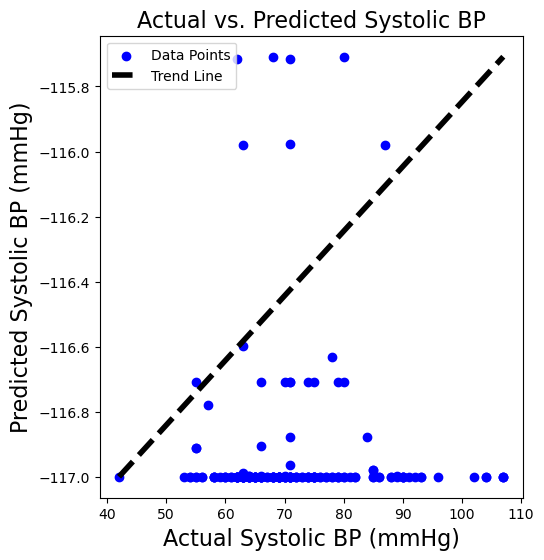

In [144]:
# Plotting actual vs. predicted Systolic Blood Pressure
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test_systolic, predicted_systolic, label='Data Points', color='blue')
plt.plot([y_test_systolic.min(), y_test_systolic.max()], [predicted_systolic.min(), predicted_systolic.max()], 'k--', lw=4, label='Trend Line')
plt.xlabel('Actual Systolic BP (mmHg)', fontsize=16)
plt.ylabel('Predicted Systolic BP (mmHg)', fontsize=16)
plt.title('Actual vs. Predicted Systolic BP', fontsize=16)
plt.legend()

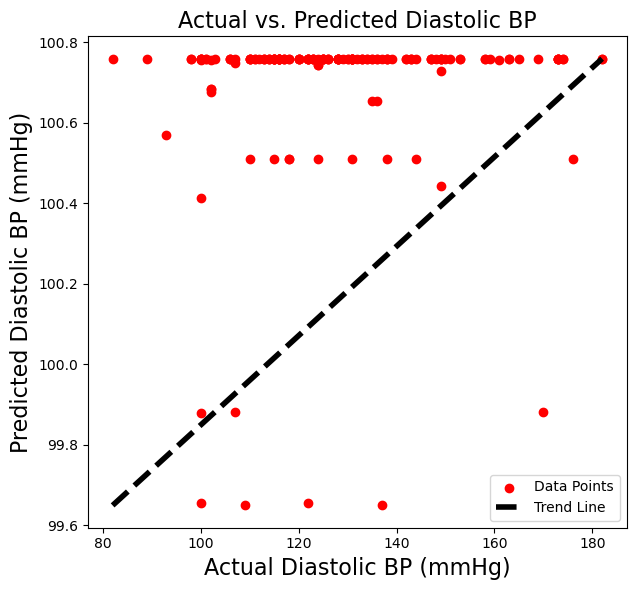

In [145]:
# Plotting actual vs. predicted Diastolic Blood Pressure
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.scatter(y_test_diastolic, predicted_diastolic, label='Data Points', color='red')
plt.plot([y_test_diastolic.min(), y_test_diastolic.max()], [predicted_diastolic.min(), predicted_diastolic.max()], 'k--', lw=4, label='Trend Line')
plt.xlabel('Actual Diastolic BP (mmHg)', fontsize=16)
plt.ylabel('Predicted Diastolic BP (mmHg)', fontsize=16)
plt.title('Actual vs. Predicted Diastolic BP', fontsize=16)
plt.legend()

plt.tight_layout()
plt.show()